In [6]:
#@title Run this to import the right things
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import sklearn.linear_model as sk

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [7]:
#@title Run this confusion matrix function
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:

## set train, validation, and test paths
train_path = '/content/gdrive/MyDrive/classifier/data/train' 
validation_path = '/content/gdrive/MyDrive/classifier/data/validation'
test_path = '/content/gdrive/MyDrive/classifier/data/test'

In [10]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = ['brokenpick', 'contamination', 'doublepick', 'hole', 'pinhole', 'slub', 'stain'], batch_size = 50)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = ['brokenpick', 'contamination', 'doublepick', 'hole', 'pinhole', 'slub', 'stain'], batch_size = 10)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = ['brokenpick', 'contamination', 'doublepick', 'hole', 'pinhole', 'slub', 'stain'], batch_size = 10)

Found 1627 images belonging to 7 classes.
Found 41 images belonging to 7 classes.
Found 1210 images belonging to 7 classes.


In [ ]:

#take a look at output of the generators

for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (50, 224, 224, 3)
labels batch shape: (50, 7)


slub


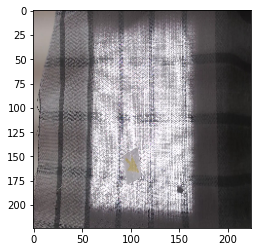

In [ ]:
##Sample images

img_path = '/content/gdrive/MyDrive/classifier/data/test/slub/d1 (13).jpg' 
img = image.load_img(img_path, target_size=(224,224))

plt.imshow(img)

print("slub")

doublepick


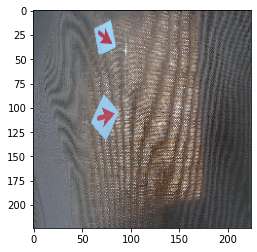

In [ ]:
img_path = '/content/gdrive/MyDrive/classifier/data/test/doublepick/img12.jpg' 
img = image.load_img(img_path, target_size=(224,224))

plt.imshow(img)

print("doublepick")

Sequential model:

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

In [ ]:
## set steps per epoch for train
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

## set steps per epoch for validation
validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
fit_generator1 = model.fit_generator(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=30,
      validation_data=validation_batches,
      validation_steps=steps_valid)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
32/32 [==============================] - 667s 20s/step - loss: 28.3600 - acc: 0.3773 - val_loss: 0.2294 - val_acc: 0.9024
Epoch 2/30
32/32 [==============================] - 164s 5s/step - loss: 0.5090 - acc: 0.8602 - val_loss: 1.2911 - val_acc: 0.8293
Epoch 3/30
32/32 [==============================] - 163s 5s/step - loss: 0.8011 - acc: 0.8592 - val_loss: 0.0964 - val_acc: 0.9512
Epoch 4/30
32/32 [==============================] - 163s 5s/step - loss: 0.1583 - acc: 0.9747 - val_loss: 0.0468 - val_acc: 1.0000
Epoch 5/30
32/32 [==============================] - 163s 5s/step - loss: 0.0976 - acc: 0.9889 - val_loss: 0.1291 - val_acc: 0.9512
Epoch 6/30
32/32 [==============================] - 163s 5s/step - loss: 0.0196 - acc: 0.9985 - val_loss: 0.3598 - val_acc: 0.8780
Epoch 7/30
32/32 [==============================] - 163s 5s/step - loss: 0.3600 - acc: 0.9546 - val_loss: 0.0770 - val_acc: 0.9512
Epoch 8/30
32/32 [==============================] - 163s 5s/step - loss: 0.0019 -

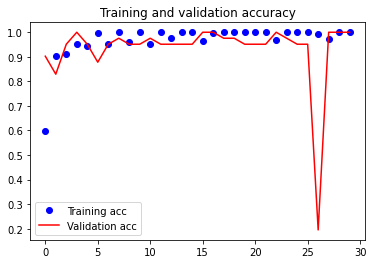

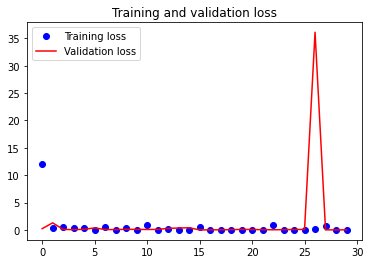

In [ ]:

import matplotlib.pyplot as plt

acc = fit_generator1.history['acc']
val_acc = fit_generator1.history['val_acc']
loss = fit_generator1.history['loss']
val_loss = fit_generator1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(layers.Dense(7 , activation='softmax'))
model2.summary()
model.save('fabrick_basic_model_dl')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)      

In [ ]:
train_datagen = ImageDataGenerator( 
         rescale=1./255,
         brightness_range=[0.5, 0.5], 
         horizontal_flip=True,
         vertical_flip=True)
        

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## set steps per epoch for train
train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

## set steps per epoch for validation
validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-6),
              metrics=['acc'])

fit_generator_3 = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=steps_valid)

Found 1627 images belonging to 7 classes.
Found 48 images belonging to 7 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
32/32 [==============================] - 168s 5s/step - loss: 1.0090 - acc: 0.6319 - val_loss: 0.8876 - val_acc: 0.7083
Epoch 2/50
32/32 [==============================] - 167s 5s/step - loss: 0.9785 - acc: 0.6500 - val_loss: 0.8850 - val_acc: 0.7083
Epoch 3/50
32/32 [==============================] - 167s 5s/step - loss: 0.9637 - acc: 0.6672 - val_loss: 0.8802 - val_acc: 0.7083
Epoch 4/50
32/32 [==============================] - 167s 5s/step - loss: 0.9760 - acc: 0.6433 - val_loss: 0.8767 - val_acc: 0.7083
Epoch 5/50
32/32 [==============================] - 167s 5s/step - loss: 0.9930 - acc: 0.6483 - val_loss: 0.8715 - val_acc: 0.7083
Epoch 6/50
32/32 [==============================] - 168s 5s/step - loss: 0.9741 - acc: 0.6486 - val_loss: 0.8672 - val_acc: 0.7083
Epoch 7/50
32/32 [==============================] - 168s 5s/step - loss: 0.9412 - acc: 0.6656 - val_loss: 0.8607 - val_acc: 0.7500
Epoch 8/50
32/32 [==============================] - 167s 5s/step - loss: 0.9602 - a

In [ ]:
model.save('fabrick_basic_model_dl')

INFO:tensorflow:Assets written to: fabrick_basic_model_dl/assets


In [ ]:
# interp = ClassificationInterpretation.from_learner(model)

In [ ]:
# interp.plot_top_losses(16,figsize=(12,13))

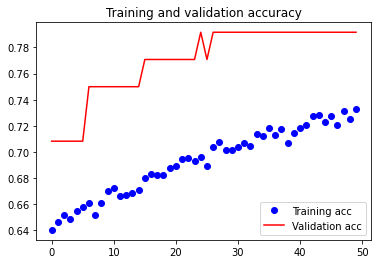

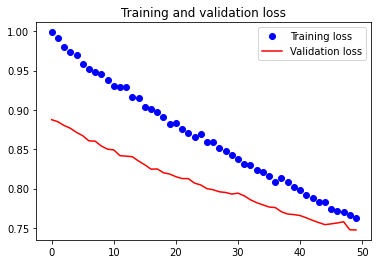

In [ ]:
import matplotlib.pyplot as plt

acc = fit_generator_3.history['acc']
val_acc = fit_generator_3.history['val_acc']
loss = fit_generator_3.history['loss']
val_loss = fit_generator_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_test_datagen = ImageDataGenerator(rescale=1./255)

model_test_generator = model_test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=2,
        shuffle = False,
        class_mode='categorical')

filenames = model_test_generator.filenames
nb_samples = len(filenames)

model_predict = model.predict_generator(model_test_generator,steps = nb_samples, verbose=2)

Found 1210 images belonging to 7 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1210/1210 - 163s


Confusion matrix, without normalization
[[ 56  27  10   0   0   2  50]
 [  0  94   0   0   0   0   6]
 [  0   0 258   0   0   5  16]
 [  0  23  24 110   0   1  34]
 [  0   0   0   0  24   0   0]
 [  0   0  11   0   0 141  66]
 [  3   3   5   2   0  26 213]]
['brokenpick/b (12).jpg', 'brokenpick/b (129).jpg', 'brokenpick/b (13).jpg', 'brokenpick/b (130).jpg', 'brokenpick/b (131).jpg', 'brokenpick/b (136).jpg', 'brokenpick/b (137).jpg', 'brokenpick/b (138).jpg', 'brokenpick/b (14).jpg', 'brokenpick/b (5).jpg', 'brokenpick/b (55).jpg', 'brokenpick/b (56).jpg', 'brokenpick/b (57).jpg', 'brokenpick/b (6).jpg', 'brokenpick/b (62).jpg', 'brokenpick/b (63).jpg', 'brokenpick/b (64).jpg', 'brokenpick/b (7).jpg', 'brokenpick/c (100).jpg', 'brokenpick/c (12).jpg', 'brokenpick/c (13).jpg', 'brokenpick/c (14).jpg', 'brokenpick/c (219).jpg', 'brokenpick/c (220).jpg', 'brokenpick/c (221).jpg', 'brokenpick/c (226).jpg', 'brokenpick/c (5).jpg', 'brokenpick/c (6).jpg', 'brokenpick/c (7).jpg', 'brokenpick

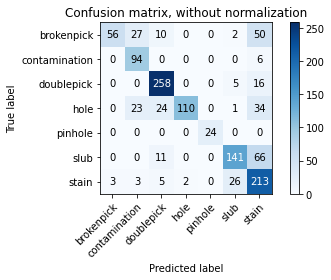

In [ ]:
y_true = model_test_generator.classes
y_pred = model_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['brokenpick', 'contamination', 'doublepick', 'hole', 'pinhole', 'slub', 'stain'],
                      title='Confusion matrix, without normalization')
#plots(test_images, titles=test_labels)
print(filenames)

VGG16 Model

In [2]:
#@title Run this to import the right things
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import keras
from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [3]:
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights = 'imagenet')

553467904/553467096 [==============================] - 3s 0us/step


In [4]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
from keras.models import Sequential
from keras.layers import Dense

vgg_transfer_base_model = Sequential()

for layer in vgg_model.layers[:-1]:
  vgg_transfer_base_model.add(layer)
  
vgg_transfer_base_model.layers.pop()
for layer in vgg_transfer_base_model.layers:
  layer.trainable=False

vgg_transfer_base_model.add(Dense(512, activation = 'relu'))
vgg_transfer_base_model.add(Dropout(0.5))
vgg_transfer_base_model.add(Dense(7, activation='softmax'))
vgg_transfer_base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [1]:
## data augmentation datagen
vgg_train_datagen_do = ImageDataGenerator(
         rescale=1./255,
         brightness_range=[0.5, 0.5], 
         horizontal_flip=True,
         vertical_flip=True)

## test generator, required for prediction
vgg_test_datagen_do = ImageDataGenerator(rescale=1./255)

## train generator
vgg_train_generator_do = vgg_train_datagen_do.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## validation generator
vgg_validation_generator_do = vgg_test_datagen_do.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## compile model
vgg_transfer_base_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-9),
              metrics=['acc'])


## set steps per epoch for train
train_filenames_do = vgg_train_generator_do.filenames
steps_train_do = len(train_filenames_do)/vgg_train_generator_do.batch_size

## set steps per epoch for validation
validation_filenames_do = vgg_validation_generator_do.filenames
steps_valid_do = len(validation_filenames_do)/vgg_validation_generator_do.batch_size

## fit model
vgg_base_fit_generator_do = vgg_transfer_base_model.fit_generator(
        vgg_train_generator_do,
        steps_per_epoch=steps_train_do,
        epochs=50,
        validation_data=vgg_validation_generator_do,
        validation_steps=steps_valid_do,
        verbose=1)

NameError: ignored

In [ ]:
vgg_transfer_base_model.save('vgg_model_dropout')

In [ ]:
import matplotlib.pyplot as plt

acc = vgg_base_fit_generator_do.history['acc']
val_acc = vgg_base_fit_generator_do.history['val_acc']
loss = vgg_base_fit_generator_do.history['loss']
val_loss = vgg_base_fit_generator_do.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
vgg_test_generator_do = vgg_test_datagen_do.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames_do = vgg_test_generator_do.filenames
nb_samples_do = len(filenames_do)

predict_do = vgg_transfer_base_model.predict_generator(vgg_test_generator_do,steps = nb_samples_do, verbose=2)

In [ ]:
do_y_true = vgg_test_generator_do.classes
do_y_pred = predict_do.argmax(axis=1)
plot_confusion_matrix(do_y_true, do_y_pred, classes=['brokenpick', 'contamination', 'doublepick', 'hole', 'pinhole', 'slub', 'stain'],
                      title='Confusion matrix, without normalization')